In [1]:
import pandas as pd
import requests
from io import BytesIO
import xgboost as xgb
from category_encoders import TargetEncoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from IPython.display import display
from sklearn import metrics
import advertools as adv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import plotly.express as px
import pickle
from xgboost import plot_importance
import plotly.graph_objects as go
import warnings
import optuna
from fitter import Fitter
warnings.filterwarnings('ignore')
import matplotlib. pyplot as plt 

In [2]:
df = pd.read_csv("/Users/birsenbas/Desktop/Kodluyoruz/finalProject/2019-2020-ismek-kesin-kaytl-kursiyer-verileri.csv", encoding="ISO-8859-1", error_bad_lines=False, delimiter=";")

Notlar:

1-33 tane alandan (kolon=Alan) en fazla tercih edilen 5 alan alınabilir (bunlar için de toplam 143265 data var yeterli olur gibi)

2-Burda modellemeden çok güzel bir analiz çıkabilir, çok fazla soru işareti doğuyor
 *en fazla kursa gidilen ilçe, kursların az tercih edildiği yerlerde teşvik edici etkinlikle düzenlenebilir gibi
 *bu ilçede en çok tercih edilen kurslar
 *hangi yaş aralığı hangi kursu daha çok tercih ediyor
 *eğitim durumuna göre kurs tercihi analizi
 *Alanlar içinde en çok tercih edilen Programlar neler
 *kişilerin kursu bitirme oranı
 *kursların genel olarak tercih sebepleri neler
 *Çalışma durumları analiz edilerek kurs saatleri ona göre düzenlenebilir

3-modelde de kişinin bilgilerine göre gideceği Alan tahmini yapılabilir. Mesela tercih sebebim meslek edinmekse, hangi kursa gitme ihtimalim yüksek (başka şeyler de olabilir, üzerine çok derin düşünemedim:)



Ekstra data:





In [3]:
df.head(5)

,Donem,Egitim Durumu,Engel Durumu,Calisma Durumu,Alan,Program,Hak Edilen Belge Tipi,Kurs Merkezi,Kurs Merkezi Ýlcesi,Tercih Sebebi,Yas Araligi
0,2019-2020,Lisans,Engeli Olmayan,Ogrenci,Dil Egitimleri,Ingilizce A2 Seviyesi,Hak Etmedi,Dil Okulu,Sisli,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi
1,2019-2020,Lise,Engeli Olmayan,Calismiyor,Spor,Fitness (Kadin),Ismek Sertifika,Silivri Spor Egitim Merkezi,Silivri,"Sanat,Muzik,Spor Vb. Yeteneklerimi Gelistirmek",20-30 Yas Arasi
2,2019-2020,Lisans,Engeli Olmayan,Ogrenci,Dil Egitimleri,Ingilizce A1 Seviyesi,Meb Sertifika,Tuzla Yayla Mahallesi,Tuzla,"Meslek Edinmek, Meslegimde Ýlerlemek",30-40 Yas Arasi
3,2019-2020,Lisans,Engeli Olmayan,Ogrenci,Spor,Crunch (Kadin),Hak Etmedi,Atasehir Kayisdagi,Atasehir,"Sanat,Muzik,Spor Vb. Yeteneklerimi Gelistirmek",20 Yas Alti
4,2019-2020,Lisans,Engeli Olmayan,Ogrenci,Spor,Stretching (Kadin),Hak Etmedi,Atasehir Kayisdagi,Atasehir,"Sanat,Muzik,Spor Vb. Yeteneklerimi Gelistirmek",20 Yas Alti


In [27]:
df1 = df.loc[df["Kurs Merkezi Ýlcesi"] == "Esenler"]

In [38]:
df["Alan"] = df["Alan"].astype(int)

<AxesSubplot:xlabel='Alan', ylabel='Density'>

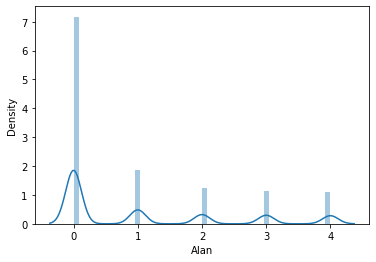

In [41]:
sns.distplot(df['Alan'])

In [42]:
pd.concat([df.isnull().sum(), 100*df.isnull().sum()/len(df)], 
          axis=1).rename(columns={0:"Missing Records", 1:"Percentage(%)"})

,Missing Records,Percentage(%)
Egitim Durumu,0,0.0
Engel Durumu,0,0.0
Calisma Durumu,0,0.0
Alan,0,0.0
Program,0,0.0
Hak Edilen Belge Tipi,0,0.0
Kurs Merkezi,0,0.0
Kurs Merkezi Ýlcesi,0,0.0
Tercih Sebebi,0,0.0
Yas Araligi,0,0.0


In [62]:
df1 = df.groupby("Egitim Durumu")[["Alan"]].count().reset_index().sort_values("Alan", ascending=False)
df1.columns = df1.columns.str.replace('Alan', 'Kişi Sayısı')
df2 = df.groupby("Engel Durumu")[["Alan"]].count().reset_index().sort_values("Alan", ascending=False)
df2.columns = df2.columns.str.replace('Alan', 'Kişi Sayısı')
df3 = df.groupby("Calisma Durumu")[["Alan"]].count().reset_index().sort_values("Alan", ascending=False)
df3.columns = df3.columns.str.replace('Alan', 'Kişi Sayısı')
df4 = df.groupby("Program")[["Alan"]].count().reset_index().sort_values("Alan", ascending=False)
df4.columns = df4.columns.str.replace('Alan', 'Kişi Sayısı')
df5 = df.groupby("Hak Edilen Belge Tipi")[["Alan"]].count().reset_index().sort_values("Alan", ascending=False)
df5.columns = df5.columns.str.replace('Alan', 'Kişi Sayısı')
df6 = df.groupby("Kurs Merkezi")[["Alan"]].count().reset_index().sort_values("Alan", ascending=False)
df6.columns = df6.columns.str.replace('Alan', 'Kişi Sayısı')
df7 = df.groupby("Kurs Merkezi Ýlcesi")[["Alan"]].count().reset_index().sort_values("Alan", ascending=False)
df7.columns = df7.columns.str.replace('Alan', 'Kişi Sayısı')
df8 = df.groupby("Tercih Sebebi")[["Alan"]].count().reset_index().sort_values("Alan", ascending=False)
df8.columns = df8.columns.str.replace('Alan', 'Kişi Sayısı')
df9 = df.groupby("Yas Araligi")[["Alan"]].count().reset_index().sort_values("Alan", ascending=False)
df9.columns = df9.columns.str.replace('Alan', 'Kişi Sayısı')
df9
df10 = df.groupby("Alan")[["Yas Araligi"]].count().reset_index().sort_values("Yas Araligi", ascending=False)
df10.columns = df10.columns.str.replace('Yas Araligi', 'Kişi Sayısı')

In [71]:
x = df_alan["Alan"]
y = df_alan["Kişi Sayısı"]

fig = px.bar(df_alan, x='Alan', y='Kişi Sayısı')
fig.show()

In [67]:
index = 1
df_alan = df10.drop(index)

In [70]:
df_alan

,Alan,Kişi Sayısı
24,Spor,23254
9,Grafik Ve Teknik Tasarim,15405
3,Dil Egitimleri,14271
11,Kisisel Gelisim Ve Egitim,13555
19,Orgu Ve Ýsleme Sanatlari,8618
15,Moda Tasarimi Ve Tekstil Teknolojisi,7198
22,Sanat Ve Tasarim,5652
4,El Sanatlari Teknolojisi,5347
5,Gastronomi Ve Mutfak Sanatlari,5213
16,Muhasebe Ve Finans,5012


In [9]:
x = df1["Egitim Durumu"]
y = df1["Kişi Sayısı"]

fig = px.bar(df1, x='Egitim Durumu', y='Kişi Sayısı')
fig.show()

In [11]:
x = df2["Engel Durumu"]
y = df2["Kişi Sayısı"]

fig = px.bar(df2, x='Engel Durumu', y='Kişi Sayısı')
fig.show()

In [12]:
x = df3["Calisma Durumu"]
y = df3["Kişi Sayısı"]

fig = px.bar(df3, x='Calisma Durumu', y='Kişi Sayısı')
fig.show()

In [24]:
df_prog = df4.head(20)

In [25]:
x = df_prog["Program"]
y = df_prog["Kişi Sayısı"]

fig = px.bar(df_prog, x='Program', y='Kişi Sayısı')
fig.show()

In [14]:
x = df5["Hak Edilen Belge Tipi"]
y = df5["Kişi Sayısı"]

fig = px.bar(df5, x='Hak Edilen Belge Tipi', y='Kişi Sayısı')
fig.show()

In [29]:
df_merkez = df6.head(20)

In [30]:
x = df_merkez["Kurs Merkezi"]
y = df_merkez["Kişi Sayısı"]

fig = px.bar(df_merkez, x='Kurs Merkezi', y='Kişi Sayısı')
fig.show()

In [53]:
index = 185
df_merkez = df6.drop(index)

In [54]:
df_merkez

,Kurs Merkezi,Kişi Sayısı
72,Fatih Bilisim Okulu,2539
74,Fatih Dil Okulu,2299
122,Kartal Yakacik Spor Egitim Merkezi,1814
167,Tuzla Spor Egitim Merkezi,1807
113,Kartal Atalar Spor Egitim Merkezi,1788
...,...,...
92,Ihkib-Csd Corap Makinaci Egitimi,30
123,Maltepe Cezaevi,24
93,Iklimlendirme Okulu,14
90,Ibb Genclik Meclisi,12


In [55]:
x = df_merkez["Kurs Merkezi"]
y = df_merkez["Kişi Sayısı"]

fig = px.bar(df_merkez, x='Kurs Merkezi', y='Kişi Sayısı')
fig.show()

In [38]:
df.columns = df.columns.str.replace('kurs_merkezi_ilcesi', 'Kurs Merkezi İlcesi')
df7.columns = df7.columns.str.replace('Kurs Merkezi Ýlcesi', 'Kurs Merkezi İlcesi')

In [40]:
x = df7["Kurs Merkezi İlcesi"]
y = df7["Kişi Sayısı"]

fig = px.bar(df7, x='Kurs Merkezi İlcesi', y='Kişi Sayısı')
fig.show()

In [48]:
index = 14
df_ilce = df7.drop(index)

In [49]:
df_ilce

,Kurs Merkezi İlcesi,Kişi Sayısı
22,Kartal,8141
17,Fatih,8042
23,Kucukcekmece,6458
34,Umraniye,5366
25,Pendik,5134
35,Uskudar,4761
31,Sultanbeyli,4652
21,Kagithane,4587
18,Gaziosmanpasa,4212
33,Tuzla,4112


In [51]:
x = df_ilce["Kurs Merkezi İlcesi"]
y = df_ilce["Kişi Sayısı"]

fig = px.bar(df_ilce, x='Kurs Merkezi İlcesi', y='Kişi Sayısı')
fig.show()

In [42]:
x = df9["Yas Araligi"]
y = df9["Kişi Sayısı"]

fig = px.bar(df9, x='Yas Araligi', y='Kişi Sayısı')
fig.show()

# yaş aralığı bazında analiz

In [127]:
df_60_yas_üstü = df.loc[df['Yas Araligi'] == '60 Yas ustu']
df_20_30_yas

,Donem,Egitim Durumu,Engel Durumu,Calisma Durumu,Alan,Program,Hak Edilen Belge Tipi,Kurs Merkezi,Kurs Merkezi Ýlcesi,Tercih Sebebi,Yas Araligi
0,2019-2020,Lisans,Engeli Olmayan,Ogrenci,Dil Egitimleri,Ingilizce A2 Seviyesi,Hak Etmedi,Dil Okulu,Sisli,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi
1,2019-2020,Lise,Engeli Olmayan,Calismiyor,Spor,Fitness (Kadin),Ismek Sertifika,Silivri Spor Egitim Merkezi,Silivri,"Sanat,Muzik,Spor Vb. Yeteneklerimi Gelistirmek",20-30 Yas Arasi
7,2019-2020,Lise,Engeli Olmayan,Calismiyor,Moda Tasarimi Ve Tekstil Teknolojisi,Giyim Uretiminde Temel Islemler,Hak Etmedi,Bagcilar Kirazli,Bagcilar,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi
12,2019-2020,Lisans,Engeli Olmayan,Ogrenci,Bilisim Teknolojileri,Powerpoint 2019 Kullanimi,Hak Etmedi,Uzaktan Egitim,Esenler,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi
13,2019-2020,Lisans,Engeli Olmayan,Ogrenci,Bilisim Teknolojileri,Blog Web Sitesi Yapimi Ve Bloggerlik,Ismek Sertifika,Uzaktan Egitim,Esenler,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi
...,...,...,...,...,...,...,...,...,...,...,...
216750,2019-2020,Lisans,Engeli Olmayan,Ogrenci,Bilisim Teknolojileri,Excel 2019 Kullanimi,Hak Etmedi,Uzaktan Egitim,Esenler,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi
216755,2019-2020,Lisans,Engeli Olmayan,Calisiyor,Grafik Ve Teknik Tasarim,Illustrator Cizim Uygulamalari 3,Hak Etmedi,Uzaktan Egitim,Esenler,"Sanat,Muzik,Spor Vb. Yeteneklerimi Gelistirmek",20-30 Yas Arasi
216761,2019-2020,Lisans,Engeli Olmayan,Ogrenci,Grafik Ve Teknik Tasarim,Illustrator Cizim Uygulamalari 3,Ismek Sertifika,Uzaktan Egitim,Esenler,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi
216762,2019-2020,Lisans,Engeli Olmayan,Ogrenci,Bilisim Teknolojileri,Egitimde Google Classroom Kullanimi,Hak Etmedi,Uzaktan Egitim,Esenler,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi


In [128]:
df11 = df_20_30_yas.groupby("Tercih Sebebi")[["Yas Araligi"]].count().reset_index().sort_values("Yas Araligi", ascending=False)
df11.columns = df11.columns.str.replace('Yas Araligi', 'Kişi Sayısı')
df11

,Tercih Sebebi,Kişi Sayısı
0,"Meslek Edinmek, Meslegimde Ýlerlemek",69458
1,"Sanat,Muzik,Spor Vb. Yeteneklerimi Gelistirmek",13242
3,Uretim Yaparak Gelir Elde Etmek,7555
2,Sosyal Cevre Edinmek,3099


In [129]:
x = df11["Tercih Sebebi"]
y = df11["Kişi Sayısı"]

fig = px.bar(df11, x='Tercih Sebebi', y='Kişi Sayısı')
fig.show()

# ilçe bazında analiz

In [107]:
df["Kurs Merkezi Ýlcesi"].value_counts()

Esenler          108485
Kartal             8141
Fatih              8042
Kucukcekmece       6458
Umraniye           5366
Pendik             5134
Uskudar            4761
Sultanbeyli        4652
Kagithane          4587
Gaziosmanpasa      4212
Tuzla              4112
Beylikduzu         3978
Atasehir           3767
Kadikoy            3678
Sisli              3479
Bagcilar           3289
Basaksehir         3184
Bahcelievler       3157
Bakirkoy           3049
Gungoren           2816
Buyukcekmece       2702
Eyupsultan         2603
Zeytinburnu        2487
Sancaktepe         2333
Esenyurt           2004
Silivri            1937
Sultangazi         1708
Cekmekoy           1708
Avcilar            1428
Maltepe             918
Catalca             751
Arnavutkoy          411
Beykoz              411
Sariyer             386
Beyoglu             257
Sile                226
Adalar              148
Name: Kurs Merkezi Ýlcesi, dtype: int64

In [108]:
df_kucukcekmece = df.loc[df['Kurs Merkezi Ýlcesi'] == 'Kucukcekmece']
df_kucukcekmece

,Donem,Egitim Durumu,Engel Durumu,Calisma Durumu,Alan,Program,Hak Edilen Belge Tipi,Kurs Merkezi,Kurs Merkezi Ýlcesi,Tercih Sebebi,Yas Araligi
8,2019-2020,Lisans,Engeli Olmayan,Calismiyor,Gastronomi Ve Mutfak Sanatlari,Hamur Teknikleri,Hak Etmedi,K.Cekmece Halkali Toplu Konutlar,Kucukcekmece,Uretim Yaparak Gelir Elde Etmek,40-50 Yas Arasi
9,2019-2020,Lisans,Engeli Olmayan,Calismiyor,Gastronomi Ve Mutfak Sanatlari,Pastaci Ciragi,Meb Sertifika,K.Cekmece Halkali Toplu Konutlar,Kucukcekmece,Uretim Yaparak Gelir Elde Etmek,40-50 Yas Arasi
10,2019-2020,Lisans,Engeli Olmayan,Calismiyor,Gastronomi Ve Mutfak Sanatlari,Seker Hamuru Ile Susleme Ve Makaron Yapim Tekn...,Ismek Sertifika,K.Cekmece Yesilova,Kucukcekmece,Uretim Yaparak Gelir Elde Etmek,40-50 Yas Arasi
30,2019-2020,Lise,Engeli Olmayan,Calismiyor,Muhasebe Ve Finans,Genel Muhasebe,Meb Sertifika,K.Cekmece Ataturk Mahallesi,Kucukcekmece,"Meslek Edinmek, Meslegimde Ýlerlemek",20 Yas Alti
48,2019-2020,Lise,Engeli Olmayan,Calismiyor,Bilisim Teknolojileri,Bilgisayarda Dokuman Hazirlama,Meb Sertifika,K.Cekmece Sefakoy,Kucukcekmece,"Sanat,Muzik,Spor Vb. Yeteneklerimi Gelistirmek",20-30 Yas Arasi
...,...,...,...,...,...,...,...,...,...,...,...
189093,2019-2020,Ilkogretim,Engeli Olmayan,Calismiyor,Guzellik Ve Sac Bakim Hizmetleri,Manikur-Pedikur Teknikleri,Hak Etmedi,K.Cekmece Sefakoy,Kucukcekmece,"Meslek Edinmek, Meslegimde Ýlerlemek",30-40 Yas Arasi
189135,2019-2020,Yuksek Lisans,Engeli Olmayan,Ogrenci,Dil Egitimleri,Ingilizce B1 Seviyesi,Ismek Sertifika,K.Cekmece Sefakoy,Kucukcekmece,"Meslek Edinmek, Meslegimde Ýlerlemek",30-40 Yas Arasi
189176,2019-2020,Lisans,Engeli Olmayan,Calisiyor,Dil Egitimleri,Yabancilar Icin Turkce A2 Seviyesi,Hak Etmedi,K.Cekmece Kanarya,Kucukcekmece,"Meslek Edinmek, Meslegimde Ýlerlemek",40-50 Yas Arasi
189185,2019-2020,Lise,Engeli Olmayan,Calisiyor,Dil Egitimleri,Yabancilar Icin Turkce A1 Seviyesi,Hak Etmedi,K.Cekmece Kanarya,Kucukcekmece,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi


In [103]:
df_kartal["Tercih Sebebi"].value_counts()

Sanat,Muzik,Spor Vb. Yeteneklerimi Gelistirmek    4490
Meslek Edinmek, Meslegimde Ýlerlemek              1526
Sosyal Cevre Edinmek                              1487
Uretim Yaparak Gelir Elde Etmek                    638
Name: Tercih Sebebi, dtype: int64

In [109]:
df12 = df_kucukcekmece.groupby("Alan")[["Kurs Merkezi Ýlcesi"]].count().reset_index().sort_values("Kurs Merkezi Ýlcesi", ascending=False)
df12.columns = df12.columns.str.replace('Kurs Merkezi Ýlcesi', 'Kişi Sayısı')
df12

,Alan,Kişi Sayısı
18,Spor,1491
5,Gastronomi Ve Mutfak Sanatlari,563
9,Kisisel Gelisim Ve Egitim,545
11,Moda Tasarimi Ve Tekstil Teknolojisi,483
1,Bilisim Teknolojileri,380
17,Sanat Ve Tasarim,378
15,Orgu Ve Ýsleme Sanatlari,376
22,Ziraat,347
4,El Sanatlari Teknolojisi,309
8,Guzellik Ve Sac Bakim Hizmetleri,239


In [110]:
x = df12["Alan"]
y = df12["Kişi Sayısı"]

fig = px.bar(df12, x='Alan', y='Kişi Sayısı')
fig.show()

In [113]:
df13 = df_kucukcekmece.groupby("Yas Araligi")[["Kurs Merkezi Ýlcesi"]].count().reset_index().sort_values("Kurs Merkezi Ýlcesi", ascending=False)
df13.columns = df13.columns.str.replace('Kurs Merkezi Ýlcesi', 'Kişi Sayısı')
df13

,Yas Araligi,Kişi Sayısı
1,20-30 Yas Arasi,1734
3,40-50 Yas Arasi,1576
2,30-40 Yas Arasi,1384
4,50-60 Yas Arasi,999
5,60 Yas ustu,388
0,20 Yas Alti,377


In [114]:
x = df13["Yas Araligi"]
y = df13["Kişi Sayısı"]

fig = px.bar(df13, x='Yas Araligi', y='Kişi Sayısı')
fig.show()

# meslek edinmek için seçilen kurslar

In [133]:
#df_meslek = df.loc[df['Tercih Sebebi'] == 'Meslek Edinmek, Meslegimde Ýlerlemek']
#df_meslek

selected_values = ['Meslek Edinmek, Meslegimde Ýlerlemek', 'Uretim Yaparak Gelir Elde Etmek']  # Seçmek istediğiniz değerler
df_meslek = df[df['Tercih Sebebi'].isin(selected_values)]

In [134]:
df_meslek

,Donem,Egitim Durumu,Engel Durumu,Calisma Durumu,Alan,Program,Hak Edilen Belge Tipi,Kurs Merkezi,Kurs Merkezi Ýlcesi,Tercih Sebebi,Yas Araligi
0,2019-2020,Lisans,Engeli Olmayan,Ogrenci,Dil Egitimleri,Ingilizce A2 Seviyesi,Hak Etmedi,Dil Okulu,Sisli,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi
2,2019-2020,Lisans,Engeli Olmayan,Ogrenci,Dil Egitimleri,Ingilizce A1 Seviyesi,Meb Sertifika,Tuzla Yayla Mahallesi,Tuzla,"Meslek Edinmek, Meslegimde Ýlerlemek",30-40 Yas Arasi
7,2019-2020,Lise,Engeli Olmayan,Calismiyor,Moda Tasarimi Ve Tekstil Teknolojisi,Giyim Uretiminde Temel Islemler,Hak Etmedi,Bagcilar Kirazli,Bagcilar,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi
8,2019-2020,Lisans,Engeli Olmayan,Calismiyor,Gastronomi Ve Mutfak Sanatlari,Hamur Teknikleri,Hak Etmedi,K.Cekmece Halkali Toplu Konutlar,Kucukcekmece,Uretim Yaparak Gelir Elde Etmek,40-50 Yas Arasi
9,2019-2020,Lisans,Engeli Olmayan,Calismiyor,Gastronomi Ve Mutfak Sanatlari,Pastaci Ciragi,Meb Sertifika,K.Cekmece Halkali Toplu Konutlar,Kucukcekmece,Uretim Yaparak Gelir Elde Etmek,40-50 Yas Arasi
...,...,...,...,...,...,...,...,...,...,...,...
216751,2019-2020,Yuksek Lisans,Engeli Olmayan,Calisiyor,Bilisim Teknolojileri,Excel Makrolara Giris,Hak Etmedi,Uzaktan Egitim,Esenler,"Meslek Edinmek, Meslegimde Ýlerlemek",30-40 Yas Arasi
216752,2019-2020,Yuksek Lisans,Engeli Olmayan,Calisiyor,Bilisim Teknolojileri,Uygulamalarla Ileri Excel Formulleri,Hak Etmedi,Uzaktan Egitim,Esenler,"Meslek Edinmek, Meslegimde Ýlerlemek",30-40 Yas Arasi
216761,2019-2020,Lisans,Engeli Olmayan,Ogrenci,Grafik Ve Teknik Tasarim,Illustrator Cizim Uygulamalari 3,Ismek Sertifika,Uzaktan Egitim,Esenler,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi
216762,2019-2020,Lisans,Engeli Olmayan,Ogrenci,Bilisim Teknolojileri,Egitimde Google Classroom Kullanimi,Hak Etmedi,Uzaktan Egitim,Esenler,"Meslek Edinmek, Meslegimde Ýlerlemek",20-30 Yas Arasi


In [146]:
df_meslek.shape

(158647, 11)

In [140]:
df14 = df_meslek.groupby("Alan")[["Kurs Merkezi Ýlcesi"]].count().reset_index().sort_values("Kurs Merkezi Ýlcesi", ascending=False)
df14.columns = df14.columns.str.replace('Kurs Merkezi Ýlcesi', 'Kişi Sayısı')
df14

,Alan,Kişi Sayısı
1,Bilisim Teknolojileri,82035
9,Grafik Ve Teknik Tasarim,13026
3,Dil Egitimleri,10518
11,Kisisel Gelisim Ve Egitim,9596
15,Moda Tasarimi Ve Tekstil Teknolojisi,5685
19,Orgu Ve Ýsleme Sanatlari,5164
16,Muhasebe Ve Finans,4850
5,Gastronomi Ve Mutfak Sanatlari,4093
31,Yonetim Ve Hizmet,3711
4,El Sanatlari Teknolojisi,3276


In [144]:
x = df14["Alan"]
y = df14["Kişi Sayısı"]

fig = px.bar(df14, x='Alan', y='Kişi Sayısı')
fig.show()